In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def seconds(time_str):
    [hrs,mins,secs] = list(map(int,time_str.split(":")))
    # hrs = hrs%24
    return np.mod(int(hrs*120 + mins*2 + secs/30),2880)

In [3]:
df = pd.read_csv('google_transit/stop_times.txt')
df['day'] = df.apply(lambda row: row['trip_id'].split("-")[2], axis=1)
df['arrival_time'] = df.apply(lambda row: seconds(row['arrival_time']), axis=1)
df['departure_time'] = df.apply(lambda row: seconds(row['departure_time']), axis=1)

In [4]:
stops = pd.read_csv('google_transit/stops.txt')

In [5]:
stops['coords'] = stops.apply(lambda row: (row['stop_lat'],row['stop_lon']), axis=1)
stops['stop_id'] = stops.apply(lambda row: row['stop_id'][0:3], axis=1)
coords = dict(zip(stops['stop_id'],stops['coords']))

In [6]:
stations = df['stop_id'].unique()
stations = np.append(stations,'140N') # add south ferry
stations = np.append(stations,'140S') # add south ferry

times = [i for i in range(120*24)]

In [7]:
trans = pd.read_csv('google_transit/transfers.txt')
trans['from_stop_id'] = trans['from_stop_id'].apply(str)
trans['to_stop_id'] = trans['to_stop_id'].apply(str)

# make a transfer dictionary
trans_dict = dict(zip(trans['from_stop_id'],zip(trans['to_stop_id'],trans['min_transfer_time'])))

In [8]:
# go through the dataframe, if two stops share a trip_id connect the earlier time to the later time
time_graph = {}

past_stop_id = df['stop_id'][0]
past_time = df['departure_time'][0]
past_trip_id = df['trip_id'][0]
counter = 0

for i in range(1,len(df)):
    current_stop_id = df['stop_id'][i]
    current_time = df['arrival_time'][i]
    current_trip_id = df['trip_id'][i]

    # connect stations you can ride between
    if current_trip_id==past_trip_id:
        if (past_stop_id, past_time) in time_graph:
            time_graph[(past_stop_id, past_time)].append(((current_stop_id, current_time),'train'))
        else:
            time_graph[(past_stop_id, past_time)] = [((current_stop_id, current_time),'train')]

    # to deal with transfers, note that there is never a scenario where you would wait at a station and only then transfer
    # (it would always be done immediately after arrival)
    # so transfers only have to connect directly after trains arrive

    # if a transfer exists
    if current_stop_id[0:3] in trans_dict:
        transfer_stop_id = trans_dict[current_stop_id[0:3]][0]

        # if youre transferring between north and south stations
        if current_stop_id[0:3]==transfer_stop_id:
            dir = current_stop_id[3]

            if dir=='N':
                transfer_stop_id += 'S'
            
            if dir=='S':
                transfer_stop_id += 'N'

            transfer_time = int(trans_dict[current_stop_id[0:3]][1]/30)

            if (current_stop_id, current_time) in time_graph:
                time_graph[(current_stop_id, current_time)].append(((transfer_stop_id, np.mod(current_time+transfer_time,2880)),'transfer'))
            else:
                time_graph[(current_stop_id, current_time)] = [((transfer_stop_id, np.mod(current_time+transfer_time,2880)),'transfer')]
        else:
        # if youre transferring between other stations, go to either north or south? data is not more specific
            transfer_time = int(trans_dict[current_stop_id[0:3]][1]/30)

            if (current_stop_id, current_time) in time_graph:
                time_graph[(current_stop_id, current_time)].append(((transfer_stop_id+'S', np.mod(current_time+transfer_time,2880)),'transfer'))
                time_graph[(current_stop_id, current_time)].append(((transfer_stop_id+'N', np.mod(current_time+transfer_time,2880)),'transfer'))
            else:
                time_graph[(current_stop_id, current_time)] = [((transfer_stop_id+'S', np.mod(current_time+transfer_time,2880)),'transfer')]
                time_graph[(current_stop_id, current_time)] = [((transfer_stop_id+'N', np.mod(current_time+transfer_time,2880)),'transfer')]

    past_stop_id = current_stop_id
    past_time = df['departure_time'][i]
    past_trip_id = current_trip_id

In [88]:
time_graph[('103S', 16)]

[(('103S', 17), 'wait'), (('103N', 22), 'transfer'), (('104S', 19), 'train')]

In [9]:
# ignoring running, you would only ever wait at a station until another event happens at that same station
# so we should find every edge entering or leaving each station, order them in time, and connect them all in time

# TEMPORARY FIX: connect every node to itself in time :(

for station in stations:
    for time in times:
        if (station, time) in time_graph:
            time_graph[(station, time)].append(((station, np.mod(time+1,2880)),'wait'))
        else:
            time_graph[(station, time)] = [((station, np.mod(time+1,2880)),'wait')]

Approximate solution: Branch and Bound (B&B)

Idea is to perform a DFS to a predefined depth which is our lookahead parameter. For all of the generated paths, we compute a heuristic like alpha*(path complexity) - beta*(makes you run a bunch) + gamma*(number of stations visited) and pick the path with the largest heuristic value. Then we jump to the end of this route and complete the same process again

In [243]:
class PathFinder():
    def __init__(self) -> None:
        self.paths = []
        self.visited = set()

    def DFS(self, node, depth, path, lookahead):
        if depth>lookahead:
            self.paths.append(path.copy())
            return

        path.append(node)

        for neighbor in time_graph[node]:
            self.DFS(neighbor,depth+1,path,lookahead)

            if len(path)>1:
                path.pop()

        return

    def do_DFS(self, starting_node, lookahead=50):
        self.DFS(node=starting_node, depth=0, path=[], lookahead=lookahead)

    def rate(self):
        # how many unique stations do the paths encounter?
        station_count = []
        for path in self.paths:
            seen = set()
            for station_id in path:
                station = station_id[0][0:3]
                # print(station)
                if station not in seen:
                    seen.add(station)
            station_count.append(len(seen))
        
        best_station_count = np.argsort(station_count)

        # waiting penalty: how long does the path spend waiting at a single station
        # waiting_penalty = []
        # for path in self.paths:
        #     past_station = path[0]

        return best_station_count[-100:]

finder = PathFinder()
finder.do_DFS(starting_node=('138N', 500), lookahead=60)
best = finder.rate()

Above doesn't really work. A different approach to generate viable paths: perform a Monte Carlo simulation of different possible paths to take (bypasses the DFS and BFS problem of taking too many express lines and transfers)

At each step there are predefined probabilities to perform certain actions: i.e. stay on the same line, transfer, wait, take the express line, etc.

In [91]:
class MonteCarlo():
    def __init__(self) -> None:
        self.paths = []
        self.visited_stations = set()
        self.time_visited_stations = {}

    def choose_next(self, current_node):
        p1 = 1 # probability that you take a train if you see one
        p2 = 0.8 # probability that you take it to a train to a station youve already been to
                 # if there are no other trains (waiting=bad)
        p3 = 0.05 # probability of transferring over waiting

        #print(current_node)
        neighbors = time_graph[current_node]
        random.shuffle(neighbors)
        types = [neighbor[1] for neighbor in neighbors]

        train_i = [i for i,type in enumerate(types) if type=='train' ]
        train_options = [neighbors[i][0] for i in train_i]
        train_options_w_time = [neighbors[i] for i in train_i]
                
        if 'train' in types:
            not_visited = [train_option for train_option in train_options if train_option[0][0:3] not in self.visited_stations]
            visited = [train_option for train_option in train_options if train_option[0][0:3] in self.visited_stations]

            # are any of the train options places we haven't yet been to?
            if len(not_visited)>0:
                #get one of them
                train_option = not_visited[0]

                if random.random()<p1:
                    # print("TRAIN!")
                    # adds station to set of those we've visited
                    self.visited_stations.add(train_option[0][0:3])

                    # records time at which we visited (will help for optimization)
                    self.time_visited_stations[train_option[0][0:3]] = train_options_w_time[0][0][1]
                    
                    return train_option
                else:
                    pass
            else:
                train_option = visited[0]
                if random.random()<p2:
                    # print("sad TRAIN!")
                    return train_option
                else:
                    pass
        
        if 'transfer' in types:
            transfer_i = [i for i,type in enumerate(types) if type=='transfer' ]
            transfer_options = [neighbors[i][0] for i in transfer_i]

            wait_i = [i for i,type in enumerate(types) if type=='wait' ]
            wait_options = [neighbors[i][0] for i in wait_i]

            if random.random()<p2:
                # print("TRANSFER")
                return transfer_options[0]
            else:
                # print("WAIT")
                return wait_options[0]
        else:
            wait_i = [i for i,type in enumerate(types) if type=='wait' ]
            wait_options = [neighbors[i][0] for i in wait_i]

            # print("WAIT")
            return wait_options[0]

    def generate_path(self, starting_node, length=1):
        path = []
        self.visited_stations = set()
        self.time_visited_stations = {}
        current_node = starting_node

        for i in range(length):
            current_node = self.choose_next(current_node)
            path.append(current_node)

        #self.paths.append(path)
        return path

    def ensemble(self, starting_node=('H11N', 500), num_candidates=100, length_candidates=10000):
        scores = []

        for i in range(num_candidates):
            path = self.generate_path(starting_node, length=length_candidates)
            self.paths.append(path)
            scores.append(len(self.visited_stations))
            if i%100==0:
                print(i)

        return scores

    def plot_route(self, route):
        lons = [coord[1] for coord in coords.values()]
        lats = [coord[0] for coord in coords.values()]

        plt.scatter(lons,lats,s=0.1,c='b')

        route_lons = [coords[station[0][0:3]][1] for station in route]
        route_lats = [coords[station[0][0:3]][0] for station in route]

        plt.scatter(route_lons,route_lats,s=0.3,c='r')

    def modify(self,path):
        # takes a random node along the path of the path and seeds a new path starting there.
        # Connect back to the main route when it gets to a station that the original path will
        # see but has not yet arrived at. There we wait...

        N = len(path)
        m = random.randint(1,N-1)
        starting_node = path[m]

        new_path = self.generate_path(starting_node, length=N-m)

        final_path = path[1:m] + new_path
        final_path = final_path[:N]
        # for station,time in new_path:
        #     if station[0:3] in old_visited_stations:
        #         time_to_get = old_time_visited_stations[station[0:3]]
        #         if time<time_to_get:
        #             if time==0:
        #                 return

                    
        #             time_found = time  #time where we found the station

        #             waiting_path = []
        #             i = time
        #             while i<time_to_get:
        #                 waiting_path.append((station,i))
        #                 i+=1
                    
        #             final_path = path[0:m] + new_path[m:time_found] + waiting_path + path[i:]
                    
        #             return final_path
        #         else:
        #             pass
        #     else:
        #         pass

        return final_path

    def anneal(self, starting_node):
        # generate first path
        path = self.generate_path(starting_node, length=2500)
        counter = 0
        # old_visited_stations = self.visited_stations.copy()
        # old_time_visited_stations = self.time_visited_stations.copy()
        top_score = len(self.visited_stations)

        p = 1 # probability that a worse path can be picked
        T = 100 # timescale of decay

        while True:
            counter += 1
            # generate new path by selecting a random element 
            # of the current path and seeding a new path
            new_path = self.modify(path)
            new_score = len(self.visited_stations)

            if new_score>top_score:
                path = new_path.copy()
                top_score = new_score
                self.paths.append(path)
            # else:
            #     if random.random()<p*np.exp(-counter/T):
            #         path = new_path.copy()
            #         top_score = new_score
            #         self.paths.append(path)
            
            print(counter)
            print(top_score)

            if counter > 1000:
                return

finder = MonteCarlo()
scores = finder.ensemble(starting_node=('101S', 720), num_candidates=1000, length_candidates=2500)

# path = finder.generate_path(('H11N', 100), length=10000)
# #finder.plot_route(1)

#finder.anneal(('101S', 720))

# new_path = finder.modify(path)

# print(len(new_path))
sorted_scores = -np.sort([-score for score in scores])
sorted_scores


0
100
200
300
400
500
600
700
800
900


array([330, 324, 308, 301, 299, 297, 294, 293, 289, 287, 285, 283, 281,
       280, 279, 278, 275, 275, 272, 272, 271, 271, 270, 269, 269, 268,
       266, 264, 264, 262, 259, 259, 257, 256, 255, 255, 252, 250, 249,
       249, 249, 248, 247, 246, 245, 244, 243, 242, 241, 241, 241, 240,
       236, 235, 234, 234, 233, 233, 233, 233, 231, 231, 230, 230, 229,
       229, 228, 228, 228, 228, 226, 226, 226, 226, 226, 225, 225, 224,
       224, 223, 223, 222, 221, 220, 220, 220, 219, 218, 217, 217, 216,
       216, 216, 215, 215, 215, 215, 214, 214, 214, 213, 212, 212, 211,
       210, 209, 209, 207, 206, 205, 205, 204, 204, 203, 203, 202, 201,
       200, 200, 200, 199, 198, 198, 198, 197, 197, 197, 196, 196, 195,
       195, 195, 194, 194, 194, 193, 192, 191, 190, 189, 188, 187, 187,
       185, 185, 184, 184, 183, 183, 182, 182, 182, 181, 181, 181, 181,
       180, 179, 179, 179, 178, 178, 178, 177, 175, 175, 174, 174, 174,
       173, 173, 173, 173, 172, 172, 171, 171, 171, 171, 171, 16

In [69]:
sorted_scores

array([328, 312, 303, 303, 300, 299, 298, 297, 295, 295, 295, 293, 293,
       291, 289, 285, 285, 284, 283, 282, 277, 276, 274, 272, 272, 270,
       270, 269, 269, 269, 269, 268, 263, 263, 263, 263, 262, 261, 260,
       260, 260, 260, 260, 260, 259, 257, 257, 257, 257, 257, 256, 256,
       256, 254, 253, 253, 253, 251, 251, 250, 250, 249, 249, 249, 249,
       248, 247, 247, 247, 245, 244, 244, 244, 243, 243, 242, 241, 240,
       240, 239, 239, 238, 238, 238, 238, 238, 238, 238, 237, 236, 236,
       235, 233, 233, 233, 232, 232, 232, 231, 231, 230, 230, 230, 229,
       229, 229, 229, 228, 228, 227, 227, 226, 226, 226, 226, 225, 225,
       224, 224, 224, 224, 223, 223, 223, 222, 222, 221, 221, 220, 220,
       219, 219, 219, 219, 218, 218, 216, 215, 215, 215, 214, 214, 214,
       213, 213, 213, 213, 212, 212, 212, 211, 210, 210, 210, 209, 209,
       208, 208, 208, 207, 206, 205, 204, 204, 204, 203, 203, 202, 202,
       202, 201, 199, 199, 198, 198, 198, 197, 197, 196, 196, 19

In [92]:
scores = -np.sort([-score for score in scores])
top = np.argsort([score for score in scores])

In [60]:
top

array([160, 774, 498, 194, 107, 342, 940, 721, 290, 367, 992, 179, 103,
       947,  62, 455, 213, 369, 698, 744, 656, 518,  41,  34, 967, 223,
       377, 725, 378, 952, 324, 478, 471, 138,  92, 999, 385, 907, 421,
       579, 368, 298, 278, 207, 190, 105, 988,   8, 519, 685, 210, 682,
       372, 540, 198, 884, 470,  48, 525, 918, 602, 228, 981, 250,  80,
       598, 480, 541, 634, 515, 978, 371, 863, 695, 283, 904, 333, 686,
       968, 738,  29, 718, 936, 610, 861, 843, 675, 308,  13, 474, 327,
       660, 937, 800,  70, 733, 466, 336, 426, 309, 775, 435, 291, 869,
       683, 499, 834, 493, 531, 693, 139, 393, 115, 167, 155, 382, 847,
       697, 867, 304,  27, 672, 549, 330, 921, 609, 120, 491, 845, 962,
       984, 315, 870,  71, 941,  86, 582, 236, 380, 362, 232, 332, 877,
         3, 311, 140, 667, 386, 171, 234, 134, 256, 261, 163, 716, 771,
       567, 122, 389, 439, 422, 778, 159, 274, 486, 789, 613, 208, 153,
       770, 479, 239, 569, 591, 917, 897,   4,  97, 125, 644, 68

In [49]:
print(len(finder.paths))

10000


In [59]:
path==new_path

False

In [77]:
finder.paths[-1][-1000:]

[('Q05N', 929),
 ('Q05N', 930),
 ('Q05N', 931),
 ('Q05N', 932),
 ('Q05N', 933),
 ('Q05N', 934),
 ('Q05N', 935),
 ('Q05N', 936),
 ('Q05N', 937),
 ('Q05N', 938),
 ('Q05N', 939),
 ('Q05N', 940),
 ('Q05N', 941),
 ('Q05N', 942),
 ('Q05N', 943),
 ('Q05N', 944),
 ('Q05N', 945),
 ('Q05N', 946),
 ('Q05N', 947),
 ('Q05N', 948),
 ('Q05N', 949),
 ('Q05N', 950),
 ('Q05N', 951),
 ('Q05N', 952),
 ('Q05N', 953),
 ('Q05N', 954),
 ('Q05N', 955),
 ('Q05N', 956),
 ('Q05N', 957),
 ('Q05N', 958),
 ('Q05N', 959),
 ('Q05N', 960),
 ('Q05N', 961),
 ('Q05N', 962),
 ('Q05N', 963),
 ('Q05N', 964),
 ('Q05N', 965),
 ('Q05N', 966),
 ('Q05N', 967),
 ('Q05N', 968),
 ('Q05N', 969),
 ('Q05N', 970),
 ('Q05N', 971),
 ('Q05N', 972),
 ('Q05N', 973),
 ('Q05N', 974),
 ('Q05N', 975),
 ('Q05N', 976),
 ('Q05N', 977),
 ('Q05N', 978),
 ('Q05N', 979),
 ('Q05N', 980),
 ('Q05N', 981),
 ('Q05N', 982),
 ('Q05N', 983),
 ('Q05N', 984),
 ('Q05N', 985),
 ('Q05N', 986),
 ('Q05N', 987),
 ('Q05N', 988),
 ('Q05N', 989),
 ('Q05N', 990),
 ('Q05N'

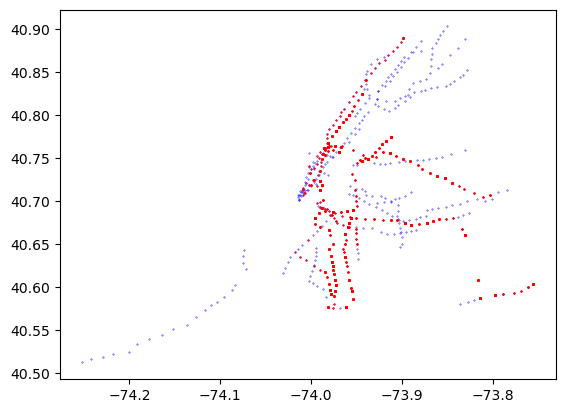

In [93]:
finder.plot_route(finder.paths[top[-1]])

In [458]:
finder.paths[ids[-1]]

[('H11N', 501),
 ('H11N', 502),
 ('H11N', 503),
 ('H11N', 504),
 ('H11N', 505),
 ('H11N', 506),
 ('H11N', 507),
 ('H11N', 508),
 ('H11N', 509),
 ('H11N', 510),
 ('H11N', 511),
 ('H11N', 512),
 ('H11N', 513),
 ('H11N', 514),
 ('H11N', 515),
 ('H11N', 516),
 ('H11N', 517),
 ('H11N', 518),
 ('H11N', 519),
 ('H11N', 520),
 ('H11N', 521),
 ('H11N', 522),
 ('H11N', 523),
 ('H11N', 524),
 ('H10N', 527),
 ('H09N', 531),
 ('H08N', 534),
 ('H07N', 538),
 ('H06N', 541),
 ('H04N', 549),
 ('H03N', 562),
 ('H02N', 566),
 ('H01N', 568),
 ('H01N', 569),
 ('H01N', 570),
 ('H01N', 571),
 ('H01N', 572),
 ('H01N', 573),
 ('H01N', 574),
 ('H01N', 575),
 ('H01N', 576),
 ('H01N', 577),
 ('H01N', 578),
 ('H01N', 579),
 ('H01N', 580),
 ('H01N', 581),
 ('H01N', 582),
 ('H01N', 583),
 ('H01N', 584),
 ('H01N', 585),
 ('H01N', 586),
 ('H01N', 587),
 ('H01N', 588),
 ('H01N', 589),
 ('H01N', 590),
 ('H01N', 591),
 ('H01N', 592),
 ('H01N', 593),
 ('H01N', 594),
 ('H01N', 595),
 ('H01N', 596),
 ('H01N', 597),
 ('H01N'

In [375]:
scores

array([222, 215, 202, 200, 199, 198, 197, 196, 195, 195, 195, 194, 194,
       193, 192, 191, 190, 190, 188, 187, 184, 182, 182, 181, 180, 179,
       179, 179, 179, 179, 178, 178, 177, 177, 177, 177, 177, 176, 176,
       175, 174, 174, 172, 172, 172, 172, 171, 171, 171, 170, 170, 170,
       170, 170, 170, 169, 169, 169, 169, 169, 168, 168, 168, 168, 167,
       167, 167, 166, 166, 166, 164, 164, 164, 163, 163, 163, 162, 162,
       162, 162, 162, 162, 161, 161, 161, 161, 161, 161, 160, 160, 160,
       160, 160, 160, 159, 159, 158, 158, 158, 158, 158, 157, 157, 157,
       157, 157, 157, 157, 156, 156, 156, 156, 156, 156, 155, 155, 155,
       155, 155, 155, 155, 155, 154, 154, 154, 154, 154, 154, 154, 154,
       154, 154, 153, 153, 153, 153, 153, 153, 152, 152, 151, 151, 151,
       151, 151, 151, 150, 150, 150, 150, 150, 150, 150, 150, 150, 149,
       149, 149, 149, 149, 148, 148, 148, 148, 148, 147, 147, 147, 147,
       147, 147, 147, 146, 146, 146, 146, 146, 146, 146, 146, 14

In [343]:
print(finder.visited_stations)

{'104', 'A47', 'F12', 'A55', 'D18', 'L21', '133', 'A40', 'H08', '113', '112', 'A63', 'L15', '114', 'G28', 'L22', 'L16', 'M10', 'M18', 'H09', 'G33', 'M14', 'A31', 'A34', 'D19', 'A61', 'A24', 'L26', 'G35', 'H11', '128', '122', 'A42', 'A44', 'A51', 'L20', '119', 'M16', 'A28', 'F09', '120', '135', '108', 'H04', 'H10', '107', 'L14', 'A46', '126', 'A32', 'L17', '131', 'A15', '129', 'L13', 'G24', 'L19', 'D21', '123', 'A33', '110', 'A12', 'A30', '115', '101', '130', 'A38', 'D20', 'M09', 'A45', 'A48', 'L27', 'G26', 'M13', 'M12', '136', 'A57', 'L28', 'L12', 'H02', 'L24', '103', '106', 'H07', 'L11', 'D15', 'G34', 'A41', 'A64', '127', 'L25', '111', '134', '117', 'H06', 'G32', 'G22', '132', '125', 'H03', 'G29', 'M11', 'A36', 'D16', '124', 'A59', 'G31', '137', '109', 'F11', '121', 'A65', 'L29', '116', 'H01', 'A27', 'A60', 'L10', 'A43', 'D17', 'G30', '118', 'G36'}


In [322]:
time_graph[('121', 500)]

KeyError: ('121', 500)

In [303]:
l = time_graph[('138N', 500)].copy()

In [304]:
l

[(('138N', 501), 'wait')]

In [244]:
len(finder.paths)

271873

In [245]:
best

array([226386,  25374,  55932,  97606,  46294, 205444,  46293,  97605,
        98948,  59685, 255975,  98951,  97604, 179575,  46170,  21636,
       174494,  64029, 118381,  74217, 252841,  74220, 102082, 185585,
        42944,  17006, 102079,  97609,  17009,  54315,  97614,  83867,
        52652, 177219, 233107, 177223,  97611,  97610, 113415,  60635,
       228838, 179571, 129665, 135291, 179320,  37030,   5952, 140540,
        22776,  48380,  89271,  22779, 177834, 174042, 177838, 192087,
       213725, 146644, 146646, 253257,  31200,  47734, 268003,  47736,
        68447,  68450,   9657, 189500, 161147, 177583,  77615, 253044,
       192539,   8249, 110999,  53079, 115566,   5858,  92837,   1987,
       226515, 172405, 149221, 224364, 132749,  97601, 244319,  74216,
        46162,  13976, 161146, 164796, 160910, 160909, 103221, 160908,
        22775, 218491, 244320,  97603])

In [246]:
finder.paths[97603]
# seen = set()
# for station_id in path:
#     station = station_id[0][0:3]
#     # print(station)
#     if station not in seen:
#         seen.add(station)
# print(len(seen))

[('138N', 500),
 ('226N', 593),
 ('225N', 596),
 ('224N', 599),
 ('221N', 609),
 ('221S', 615),
 ('221S', 616),
 ('221S', 617),
 ('221S', 618),
 ('222S', 623),
 ('415N', 629),
 ('415N', 630),
 ('415N', 631),
 ('415N', 632),
 ('415N', 633),
 ('415N', 634),
 ('415N', 635),
 ('415N', 636)]

In [141]:
max_val = 0
for id,val in enumerate(visited):
    if val[1]>max_val:
        max_val = val[1]
        print(val)

('101S', 13)
('103S', 16)
('103N', 22)
('103N', 23)
('104N', 25)
('103S', 29)
('103S', 30)
('107N', 31)
('107N', 32)
('108N', 33)
('108N', 34)
('109N', 36)
('109N', 37)
('110N', 39)
('107S', 40)
('111N', 42)
('106S', 43)
('A09N', 46)
('111S', 49)
('111S', 50)
('110S', 52)
('114N', 53)
('109S', 54)
('115N', 56)
('108S', 57)
('116N', 59)
('107S', 60)
('117N', 63)
('117N', 64)
('118N', 65)
('104S', 66)
('119N', 67)
('103S', 69)
('A03S', 70)
('120N', 71)
('A05N', 72)
('121N', 75)
('A06N', 76)
('122N', 77)
('A07N', 78)
('107S', 80)
('124N', 83)
('A07S', 85)
('124S', 89)
('124S', 90)
('A05S', 91)
('127S', 93)
('122S', 94)
('A03S', 96)
('R16N', 99)
('128N', 100)
('128N', 101)
('119S', 103)
('A17N', 104)
('118S', 105)
('117S', 107)
('A15N', 108)
('A07N', 109)
('116S', 112)
('D13N', 115)
('R14S', 116)
('D12N', 118)
('R11N', 125)
('R11N', 126)
('D11S', 127)
('D11S', 128)
('D10S', 132)
('D10S', 133)
('D09S', 136)
('D09S', 137)
('D08S', 140)
('D08S', 141)
('D08S', 142)
('R30S', 150)
('R30N', 156)
